Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [75]:
# Used to handle input/output directory operation on kaggle 
!rm -rf ./data-sikn-cancer/
!cp -R ../input/data-sikn-cancer/ ./

### Importing all the important libraries

In [76]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [77]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

## kaggle output dir path 
dir_path = "./data-sikn-cancer/" 


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [78]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(dir_path +"Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(dir_path +'Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [79]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [80]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [81]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [82]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [83]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

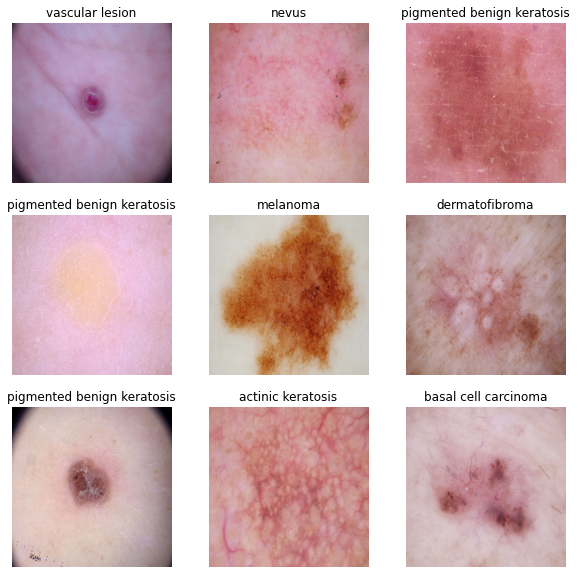

In [84]:
### your code goes here, you can use training or validation data to visualize
# Display first 20 images of moles
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [85]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [86]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [87]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0058823535 0.9985296


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [88]:
# compliling model
num_classes = 9

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [89]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [91]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 95ms/step - loss: 2.1194 - accuracy: 0.2084 - val_loss: 1.8682 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.8284 - accuracy: 0.3480 - val_loss: 1.6123 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5826 - accuracy: 0.4547 - val_loss: 1.6382 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4970 - accuracy: 0.4819 - val_loss: 1.3747 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2946 - accuracy: 0.5567 - val_loss: 1.3220 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2687 - accuracy: 0.5591 - val_loss: 1.3480 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1450 - accuracy: 0.6025 - val_loss: 1.4434 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing training results

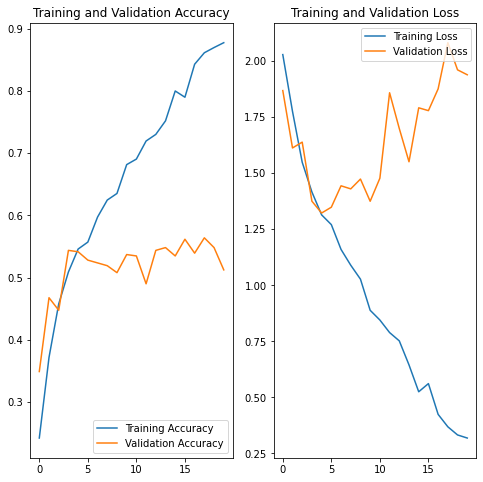

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# Inference from model 1 : 
The Training accuracy and the validation accuracy are off by large margin and the model achieve 55% of the validation accuracy.
let's look what what's wrong with the model and try to increase the performance.

Overfitting :- In the above polt we observe that the training accuracy increases over the time but the validation accuracy is stuck around 55%. Also the difference between training and validation accuracy is noticiable - is a sign of overfitting. 

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


In [93]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
  ])

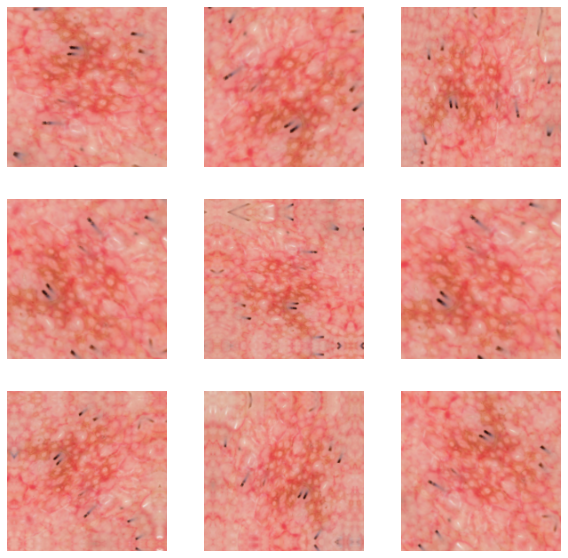

In [94]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [95]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compiling the model

In [96]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [97]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.3300 - accuracy: 0.1845 - val_loss: 2.0083 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 2.0379 - accuracy: 0.2188 - val_loss: 1.8791 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7862 - accuracy: 0.3560 - val_loss: 1.6341 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5538 - accuracy: 0.4335 - val_loss: 1.5205 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4593 - accuracy: 0.4766 - val_loss: 1.4387 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3601 - accuracy: 0.5255 - val_loss: 1.3927 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3391 - accuracy: 0.5328 - val_loss: 1.3644 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

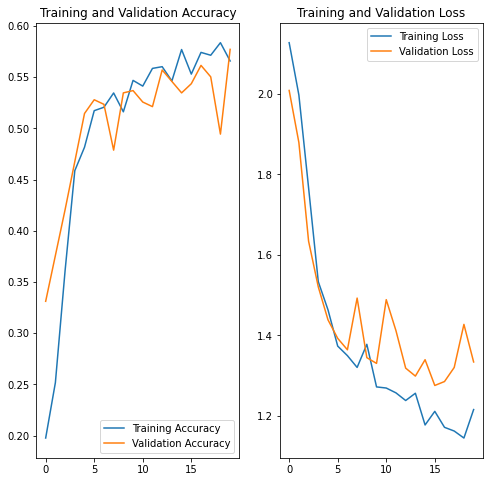

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# inference from Model 2: 

We observe that the training accuracy and validation accuracy is increases to 60%. Also, the gap between training and validation loss function decreased. 
The overfitting has been reduced effecctively after inclusion of data augumentation and dropout layer.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [99]:
## Your code goes here.
from pathlib import Path

# class_names
for name in class_names: 
    dir_path = pathlib.Path(str(data_dir_train)+ "/" + name)
    paths1 = Path(dir_path).glob('**/*.jpg')
    print(name + " "+ str(len(list(paths1))))
    

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? `seborrheic keratosis`
#### - Which classes dominate the data in terms proportionate number of samples? `pigmented benign keratosis`


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [100]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [101]:
path_to_training_dataset=str(data_dir_train.absolute())
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC27C09CB10>: 100%|██████████| 500/500 [00:14<00:00, 33.50 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC249B5BED0>: 100%|██████████| 500/500 [00:15<00:00, 32.05 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC2493EB5D0>: 100%|██████████| 500/500 [00:15<00:00, 32.42 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC27D3C22D0>: 100%|██████████| 500/500 [01:25<00:00,  5.88 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC720018910>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC27D73E7D0>: 100%|██████████| 500/500 [01:17<00:00,  6.44 Samples/s]                    
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC249208E90>: 100%|██████████| 500/500 [00:15<00:00, 32.40 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC2493E8ED0>: 100%|██████████| 500/500 [00:38<00:00, 13.16 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC7211E3350>:   0%|          | 1/500 [00:00<00:43, 11.47 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC27D3CC4D0>: 100%|██████████| 500/500 [00:15<00:00, 33.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC249351590>: 100%|██████████| 500/500 [00:15<00:00, 32.15 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [102]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [103]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026525.jpg_8e64f689-7357-4ec0-8518-9c34775d3815.jpg',
 'data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000091.jpg_dc5e8ec2-892e-4f03-a608-b2ffa55d81ea.jpg',
 'data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000353.jpg_12be22fd-e1df-4948-ae44-47d52403e68b.jpg',
 'data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025953.jpg_bc3e76b7-aeb4-4213-96d7-473b31014fef.jpg',
 'data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000528.jpg_e94ae3d6-623a-48fa-b04f-6b0906c68874.jpg']

In [104]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [105]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [106]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df.head()

,Path,Label
0,data-sikn-cancer/Skin cancer ISIC The Internat...,nevus
1,data-sikn-cancer/Skin cancer ISIC The Internat...,nevus
2,data-sikn-cancer/Skin cancer ISIC The Internat...,nevus
3,data-sikn-cancer/Skin cancer ISIC The Internat...,nevus
4,data-sikn-cancer/Skin cancer ISIC The Internat...,nevus


In [107]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
basal cell carcinoma          500
pigmented benign keratosis    500
vascular lesion               500
nevus                         500
actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [108]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [109]:

data_dir_train=pathlib.Path("./data-sikn-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [110]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [111]:
## your code goes here
normalization_layer_final = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds_final = train_ds.map(lambda x, y: (normalization_layer_final(x), y))
image_batch_final, labels_batch_final = next(iter(normalized_ds_final))
first_image_final = image_batch_final[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_final), np.max(image_batch_final)) 

0.13889101 1.0


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [112]:
## your code goes here
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [113]:
epochs = 30
## Your code goes here, use 50 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 188ms/step - loss: 2.1788 - accuracy: 0.2107 - val_loss: 1.5073 - val_accuracy: 0.4432
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4720 - accuracy: 0.4381 - val_loss: 1.3824 - val_accuracy: 0.4811
Epoch 3/30
169/169 [==============================] - 32s 186ms/step - loss: 1.2576 - accuracy: 0.5284 - val_loss: 1.2175 - val_accuracy: 0.5546
Epoch 4/30
169/169 [==============================] - 32s 185ms/step - loss: 1.0570 - accuracy: 0.6122 - val_loss: 1.0908 - val_accuracy: 0.6095
Epoch 5/30
169/169 [==============================] - 32s 184ms/step - loss: 0.9026 - accuracy: 0.6684 - val_loss: 0.9269 - val_accuracy: 0.6756
Epoch 6/30
169/169 [==============================] - 32s 187ms/step - loss: 0.7331 - accuracy: 0.7306 - val_loss: 0.9097 - val_accuracy: 0.6837
Epoch 7/30
169/169 [==============================] - 32s 184ms/step - loss: 0.6237 - accuracy: 0.7820 - val_loss: 0.9717 - val_ac

#### **Todo:**  Visualize the model results

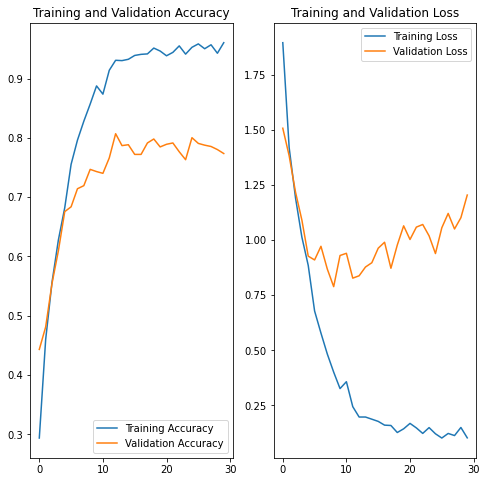

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We Observe that in both training and validation accuracy and loss function both has increased in a good amount and gap between them is less in this model as compared to previous ones. Due to gap the chance of overfitting is also reduced. This model is good to go now. We will use this model for the prediction. If we train the model on more than 30 epchos then the accuray in incresing.